In [12]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from typhon.datasets.dataset import InvalidFileError
from typhon.files import FileSet, NoFilesError
from typhon.plots import styles
import hirs_src as src
import os
with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            import typhon.datasets.tovs

styles.use('typhon')

Unable to import coda, won't read IASI EPS L1C. If you need to read IASI EPS L1C, please obtain CODA from http://stcorp.nl/coda/ and install.  Good luck.


# Select HIRS files for specific timespan

In [24]:
SATELLITE, CHANNEL = "noaa15", 8
START_DATE, END_DATE = '2020-01', '2020-12'
dates = np.arange(START_DATE, END_DATE, dtype='datetime64[D]')


In [25]:
# Find all filenames for given dates from above and store them in dict
HIRS_DATA = f"/scratch/uni/u237/data/hirs/{SATELLITE}_hirs_"
hirs_moon_files = FileSet(path = HIRS_DATA + "{year}/{month}/{day}/"
                          "NSS.HIRX.*.D*.S{hour}{minute}.E{end_hour}{end_minute}*.gz")
# Set up dictionairy which contains all files 
# for each of the dates / timestamps from above
files_dict = {}
for i in range(len(dates)):
    files_dict[dates[i]] = []
    try:
        # search for all files which correspond to date i and append them to the dictionary
        for file in hirs_moon_files.find(start = dates[i], end = dates[i] + np.timedelta64(1, 'D')):
            files_dict[dates[i]].append(file.path)
        # if no files are found for date i continue with next iteration step
    except NoFilesError:
        continue
        
#print(files_dict)

# Search for intrusions by the gradient of counts in between scanlines

In [26]:
# Create list of file_names with potential moon intrusions by opening all the files in files_dict and looking
# for cases where counts in deep space view (dsv) shift by more than 50 from one "scanline" to the next 
# (e.g. show gradients between scanlines of more than 50 counts difference). 

print(f'Checking HIRS data of {SATELLITE}, channel {CHANNEL},')
# set up hirs data handler and print hirs instrument
read_hirs = src.get_hirs_reader(SATELLITE)
print(f'in timeslot {START_DATE} - {END_DATE}:')
print('########################################')
print('')
current_month = str(np.datetime64(dates[0],'M'))
print (f'Checking {current_month} for intrusions...')

possible_intrusions = []

# loop through every day given in dates
for i in range(len(dates[:])):
    
    # print month which is currently checked for intrusions
    if (i > 0) & (np.datetime64(dates[i],'M') != np.datetime64(dates[i-1],'M')):
        current_month = str(np.datetime64(dates[i],'M'))
        print('')
        print(f'Checking {current_month} for intrusions...')
    
    # loop through every granule file of day i
    for file in files_dict[dates[i]]:
        
        # try to read the granule file, raise error if not possible
        # but continue with loop
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            try:
                (lines, extra) = read_hirs.read(file)
            except (typhon.datasets.tovs.dataset.InvalidDataError, InvalidFileError) as e: 
                print('   FileError')
                continue
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")

        # convert data to xarray dataset    
        ds = read_hirs.as_xarray_dataset(lines)

        # array of dsv counts of all scanlines
        counts = ds[{"time":ds["scantype"]==1}]["counts"].sel(scanpos=range(8,56),channel=CHANNEL)
    
        # check if gradient of dsv counts between scanlines is somewhere
        # higher than chosen lower bound threshold value (-> possible intrusion) 
        # and lower than upper bound threshold value (-> instrument error)
        counts_gradients_scanlines = np.diff(counts.mean(axis=1))
        if ((np.abs(counts_gradients_scanlines) > 50).any()) & \
            ((np.abs(counts_gradients_scanlines) < 15.e3).all()) == True:
        
            # find scanline of intrusion by searching for the 
            # scanline with the minimum average of counts
            timeindex_intrusion = counts.mean(dim="scanpos").argmin()
            timestamp_intrusion = counts.time[timeindex_intrusion]
            
            try:
                intrusion_scanline_counts = ds[{"time":ds["scantype"]==1}]["counts"].sel(
                    time=timestamp_intrusion,scanpos=range(10,56),channel=CHANNEL).sel()
            except:
                print('   DimError')
                continue

            # check if gradients of dsv counts in intrusion scanline are below choosen
            # threshold value and are nonzero to filter out 
            # the scanlines with intstrument errors:
            counts_gradients_intrusion_scanline = np.diff(intrusion_scanline_counts)
            if ((np.abs(counts_gradients_intrusion_scanline) < 500).all()) & \
            ((np.abs(counts_gradients_intrusion_scanline) != 0.).any()):
        
                print('')
                print(f'   *** Detected possible intrusion in:')
                print('   ***',file)
                print('')

                possible_intrusions.append(file)
        
print('########################################')
print(f'Detected {len(possible_intrusions)} possible intrusions.')

# Save list of granule files which include 
# possible intrusions to txt file. (Default Path: local directory)
PATH = 'hirs_moon_intrusion_suspect_files/'
FILE = f'hirs_moon_intrusions_{SATELLITE}_CH{CHANNEL}_{START_DATE}_{END_DATE}.txt'
textfile = open(PATH+FILE, "w")

textfile.write("GRANULE FILES WHICH INCLUDE POSSIBLE MOON INTRUSIONS FOR\n")
textfile.write(f"Satellite: {SATELLITE}, Channel: {CHANNEL}\n")
textfile.write(f"Timeslot: {START_DATE} - {END_DATE}\n")
textfile.write("==============================\n")
textfile.write("\n")

for element in possible_intrusions:
    textfile.write(element + "\n")

textfile.close()

print('\nPaths to files with possible intrusions saved in text file:')
print(PATH+FILE)

Checking HIRS data of noaa15, channel 8,
instrument: HIRS3
in timeslot 2020-01 - 2020-12:
########################################

Checking 2020-01 for intrusions...

   *** Detected possible intrusion in:
   *** /scratch/uni/u237/data/hirs/noaa15_hirs_2020/01/10/NSS.HIRX.NK.D20010.S2225.E0019.B1266566.GC.gz


   *** Detected possible intrusion in:
   *** /scratch/uni/u237/data/hirs/noaa15_hirs_2020/01/10/NSS.HIRX.NK.D20010.S2225.E0019.B1266566.GC.gz


   *** Detected possible intrusion in:
   *** /scratch/uni/u237/data/hirs/noaa15_hirs_2020/01/11/NSS.HIRX.NK.D20011.S0015.E0146.B1266667.GC.gz


Checking 2020-02 for intrusions...

   *** Detected possible intrusion in:
   *** /scratch/uni/u237/data/hirs/noaa15_hirs_2020/02/09/NSS.HIRX.NK.D20040.S0111.E0256.B1308081.GC.gz


Checking 2020-03 for intrusions...

Checking 2020-04 for intrusions...

   *** Detected possible intrusion in:
   *** /scratch/uni/u237/data/hirs/noaa15_hirs_2020/04/08/NSS.HIRX.NK.D20099.S1009.E1158.B1392627.WI.gz



# Plot all (suspected) intrusion scans

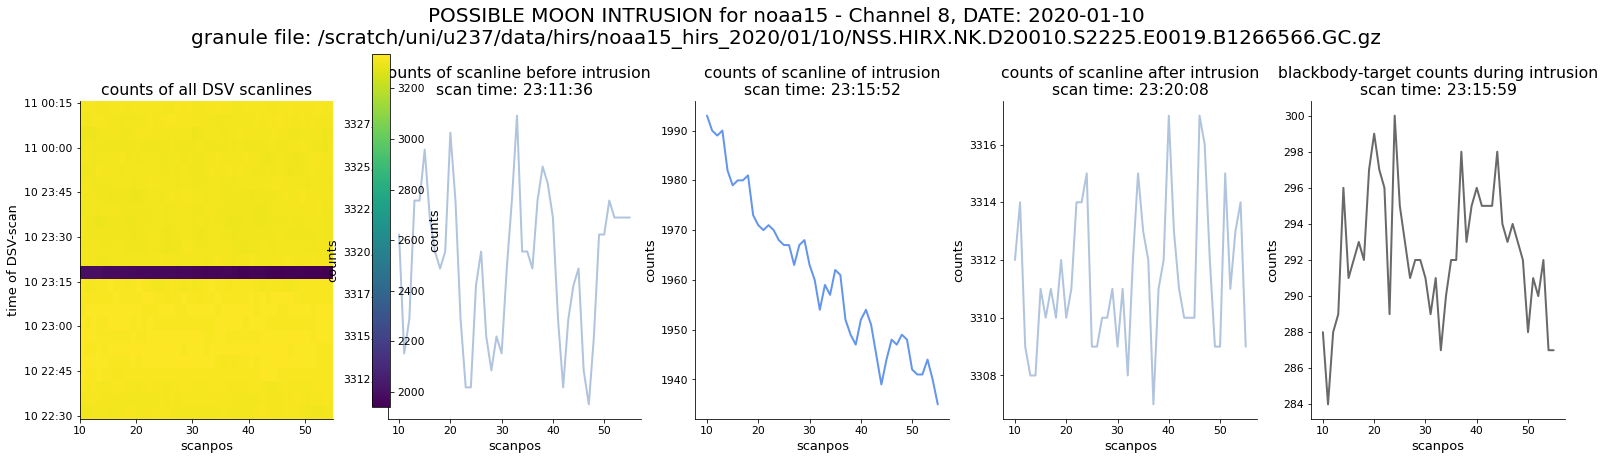

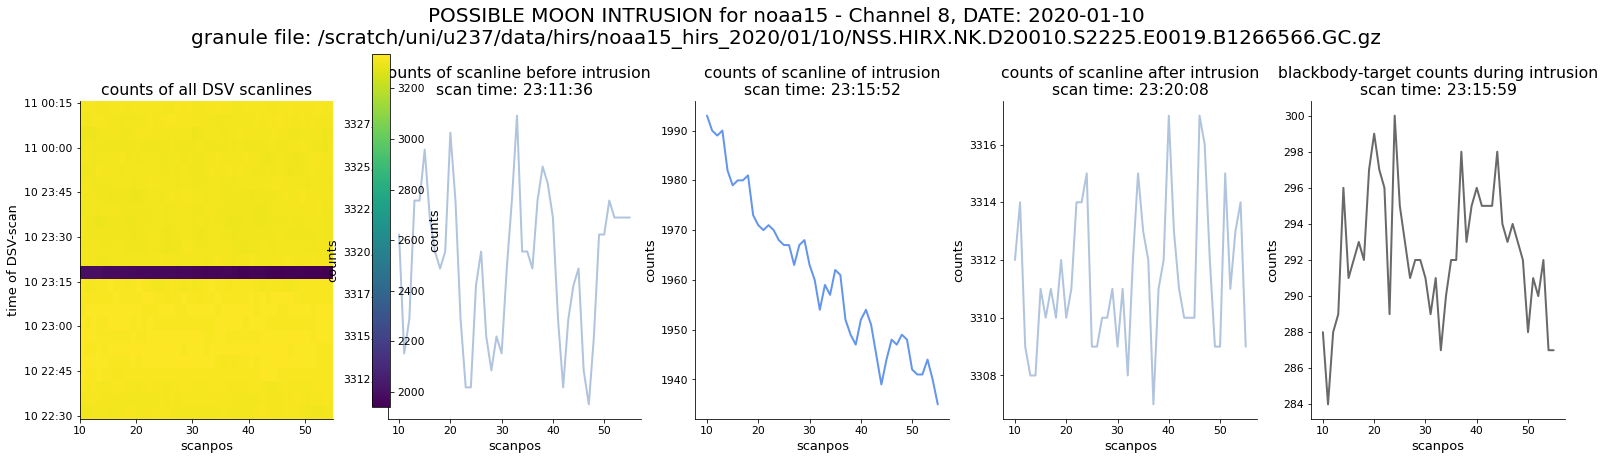

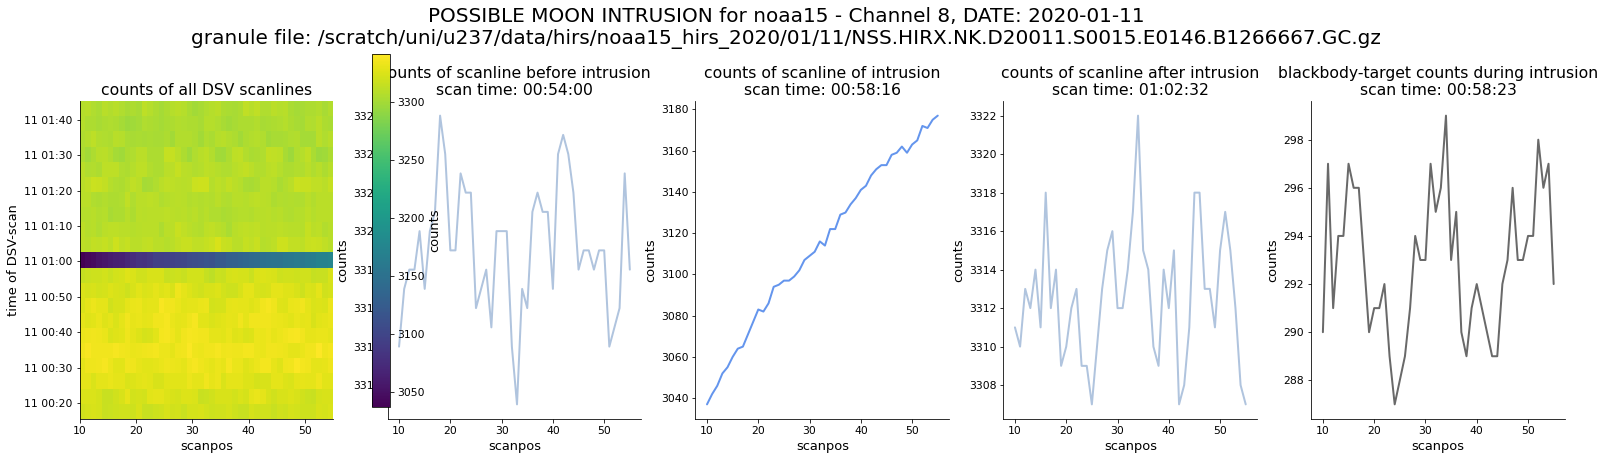

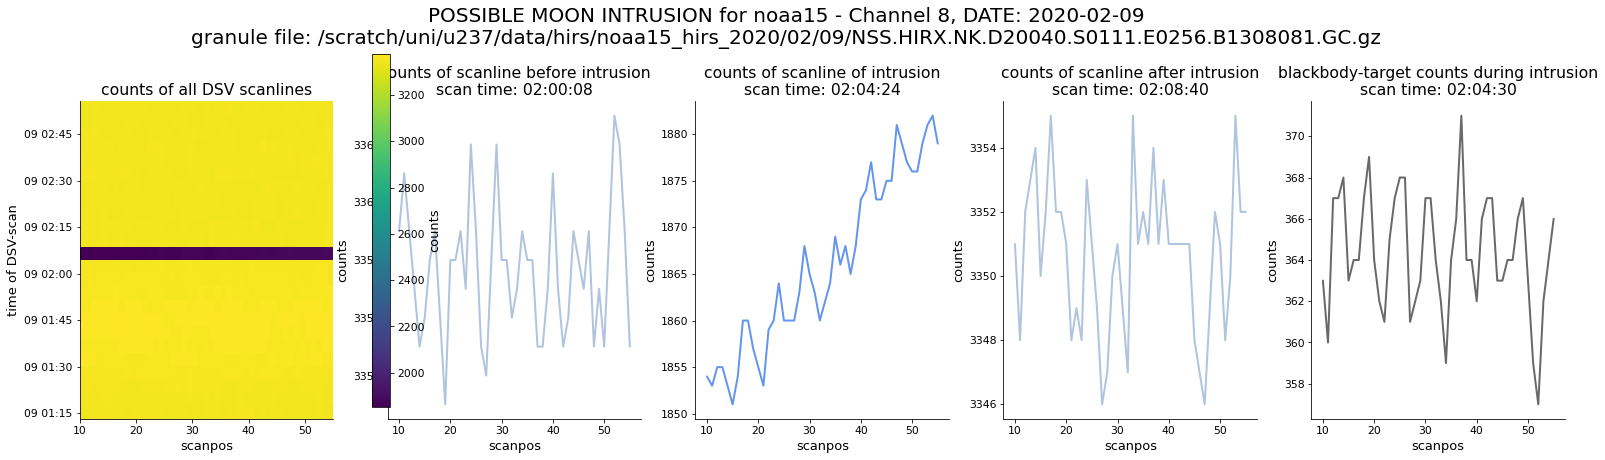

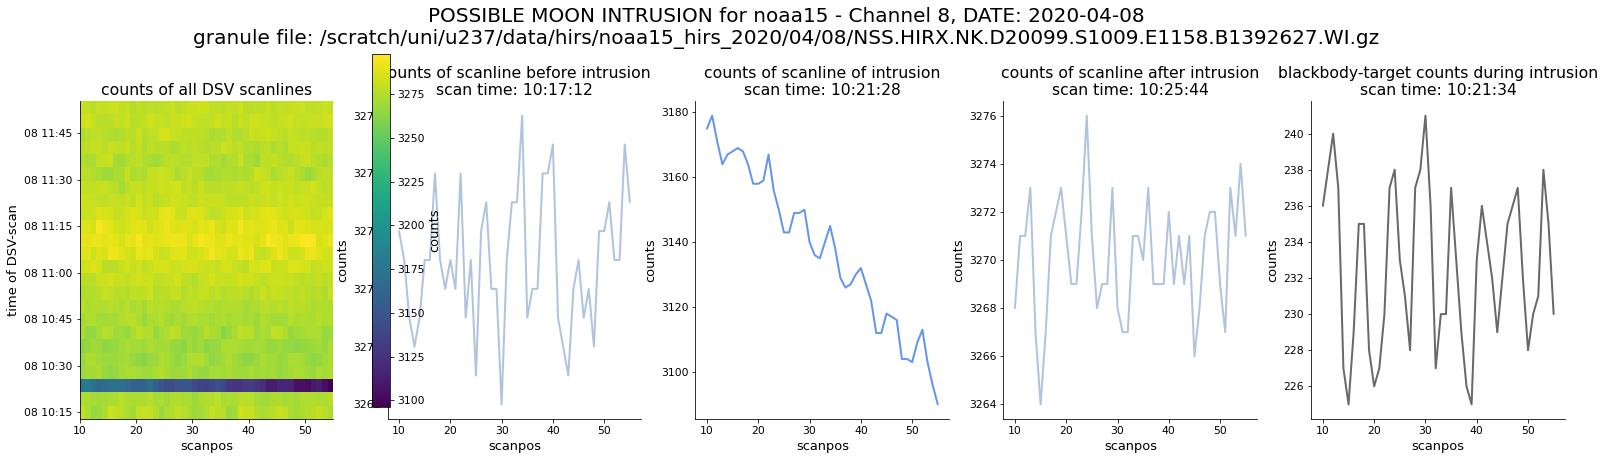

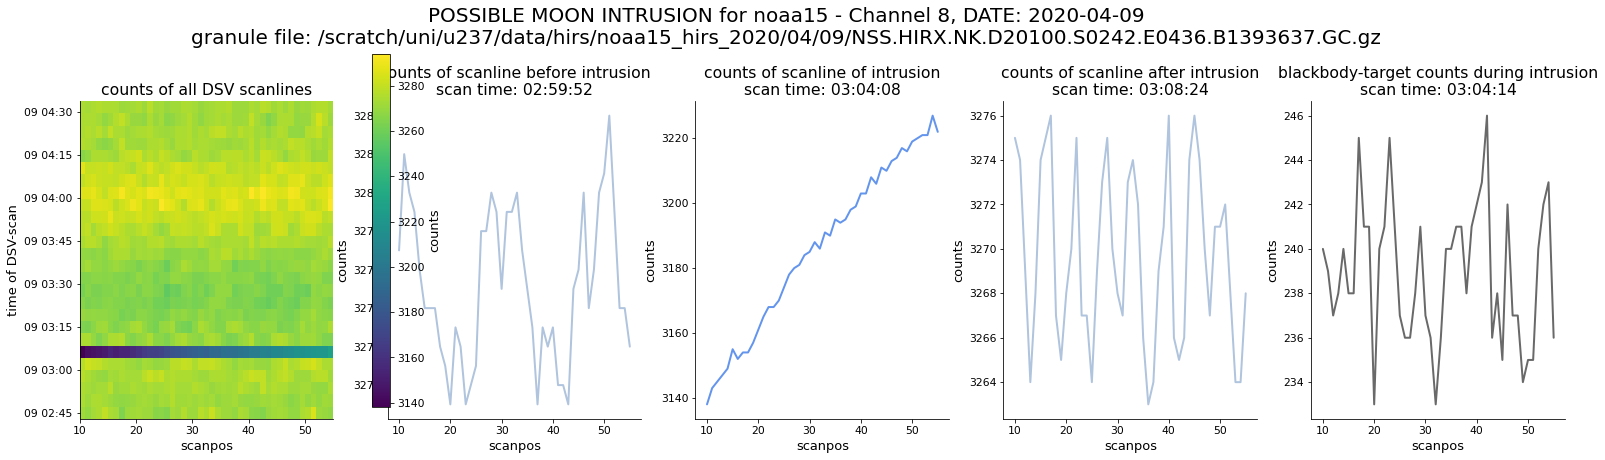

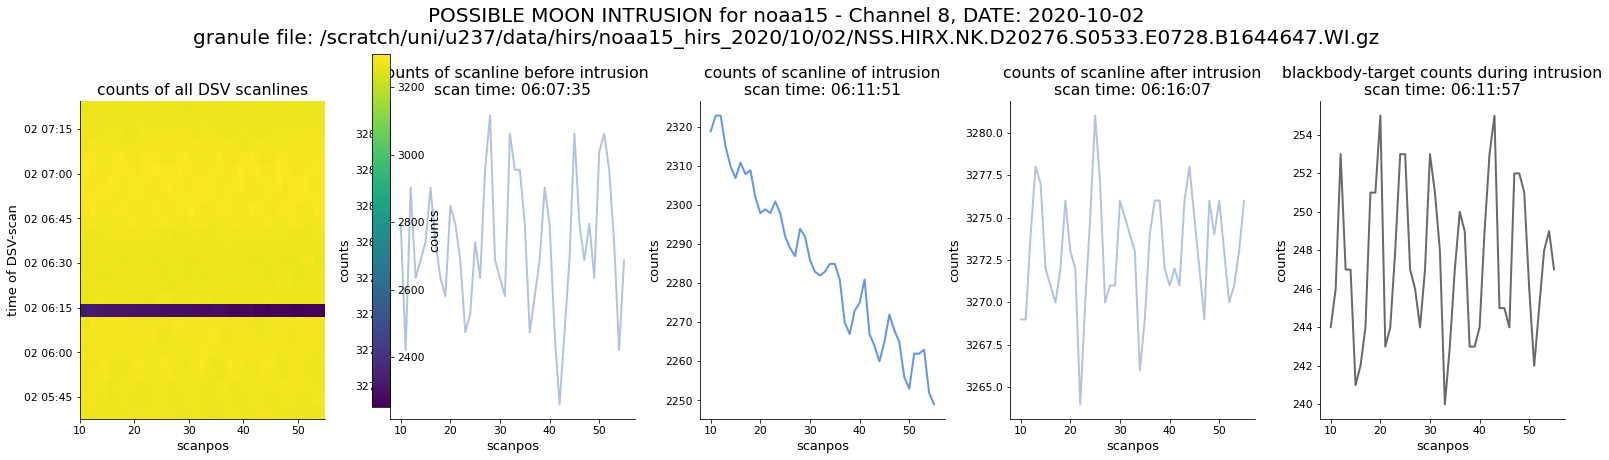

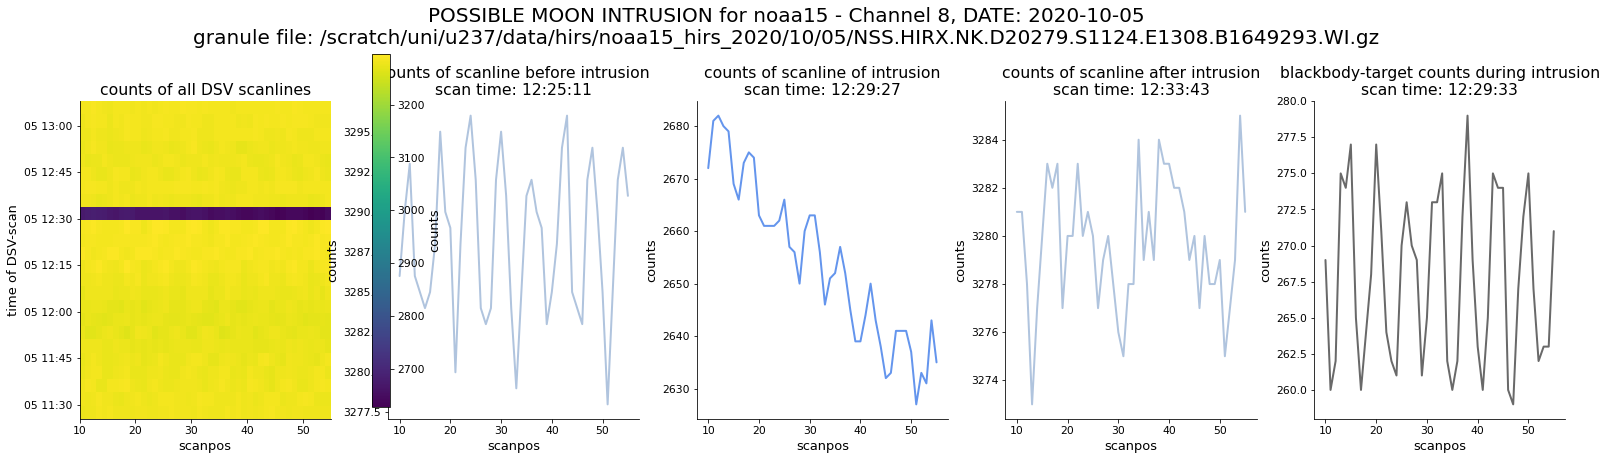

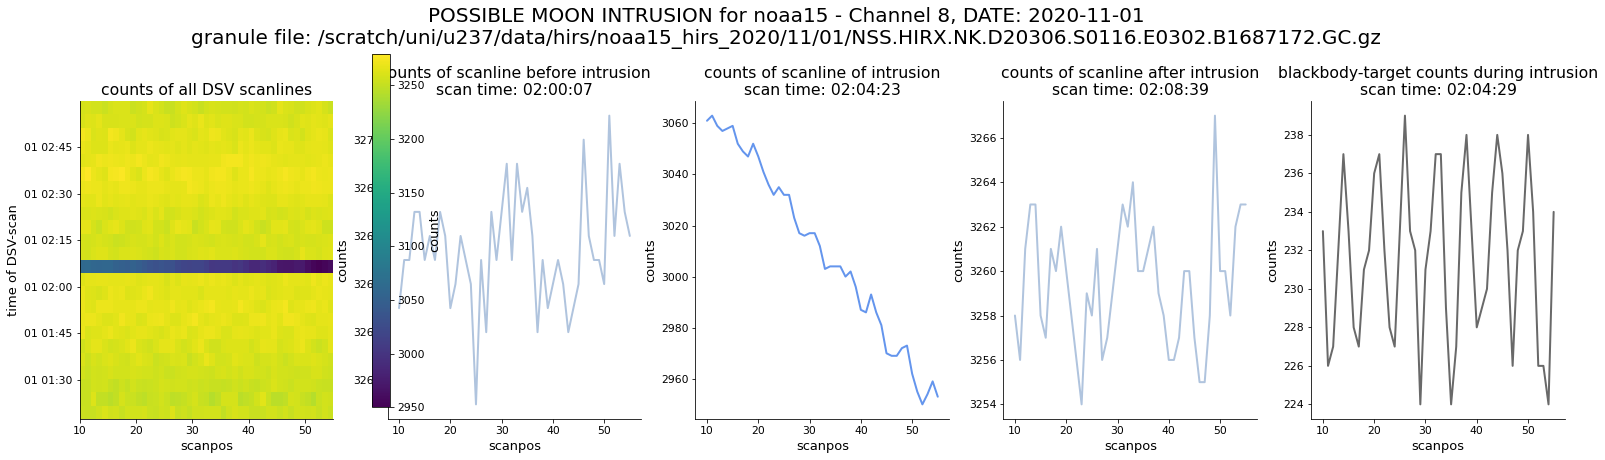

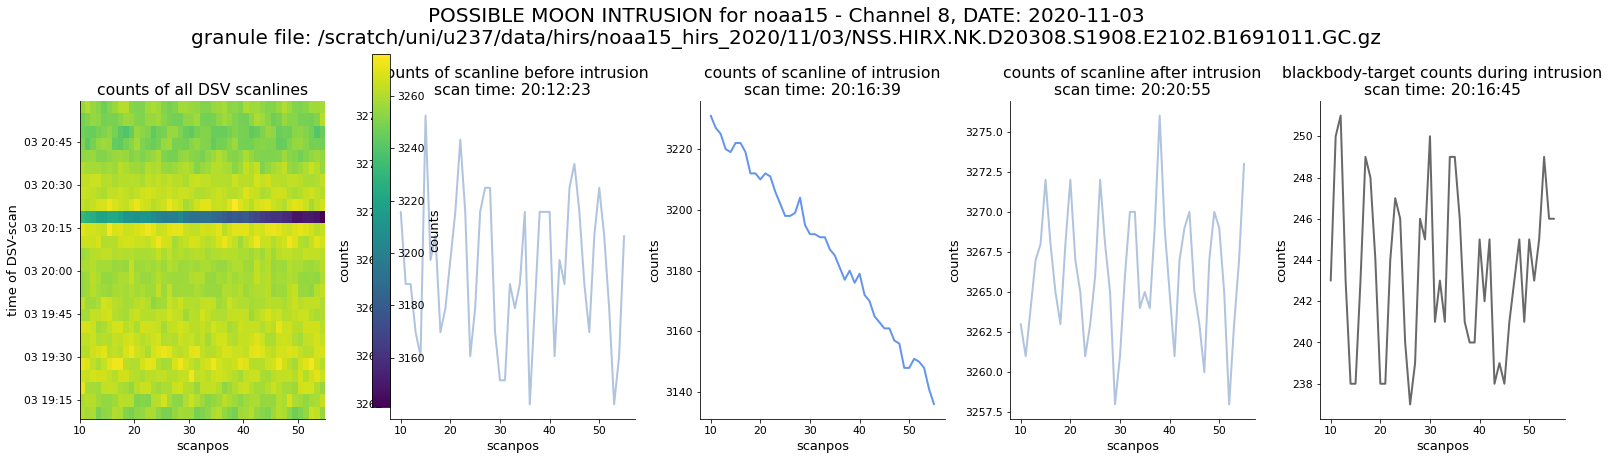

In [28]:
warnings.filterwarnings('ignore')
# Plot data of moon intrusion files

# change to 'true' if plots should be saved
savefig = False

# look for directory 'hirs_moon_intrusion_suspects_plots'. 
# If it's not exisiting already, create it.
directory = 'hirs_moon_intrusion_suspects_plots'
if not os.path.exists(directory):
    os.makedirs(directory)

# read in output-textfile for the specified 
# satellite, channel and timeslot:
txtfile_header = 5
intrusion_list = []
with open(f'hirs_moon_intrusions_'
          f'{SATELLITE}_CH{CHANNEL}_{START_DATE}_{END_DATE}.txt','r') as txtfile:
    
    intrusion_list = txtfile.readlines()

# generate list of all paths to hirs-files containing possible intrusions
intrusion_list = [intrusion_list[txtfile_header:][file].rstrip("\n") 
                  for file in range(len(intrusion_list[txtfile_header:]))]

# loop through every file of the list and plot its data
for file in intrusion_list:  
    
    with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            
            # read hirs-file as xarray dataset
            (lines, extra) = read_hirs.read(file)
            ds = read_hirs.as_xarray_dataset(lines)

    # dsv counts of all scanlines        
    counts_dsv = ds[{"time":ds["scantype"]==1}]["counts"].sel(
        scanpos=range(10,56),channel=CHANNEL)
    
    # bb counts of all scanlines
    counts_bb = ds[{"time":ds["scantype"]==3}]["counts"].sel(
        scanpos=range(10,56),channel=CHANNEL)
    
    # find dsv scanline of intrusion by searching for the 
    # scanline with the minimum average of counts:
    timeindex_of_intrusion = counts_dsv.mean(dim="scanpos").argmin()
    
    try: 
        # dsv counts of scanlines during, before and after the intrusion
        scanline_of_intrusion_counts = counts_dsv.isel(time=timeindex_of_intrusion)
        scanline_before_intrusion_counts = counts_dsv.isel(time=timeindex_of_intrusion-1)
        scanline_after_intrusion_counts = counts_dsv.isel(time=timeindex_of_intrusion+1)

        # bb counts of scanline during intrusion
        blackbody_during_intrusion_counts = counts_bb.isel(time=timeindex_of_intrusion)

    except IndexError:
        print(f'! IndexError for file: {file}')
        continue
    
    # set general text size of plot 
    plt.rcParams['font.size'] = '13'     
        
    try:
        # plotting routine
        (fig, axes) = plt.subplots(ncols=5, figsize=(22,6.5))  

        # plot all dsv counts of all scanlines and set title  
        pc = axes[0].pcolormesh(counts_dsv.scanpos,
                                counts_dsv.time,
                                counts_dsv)
        fig.colorbar(pc,ax=axes[0],label='counts')
        axes[0].set(title='counts of all DSV scanlines',
                    xlabel='scanpos',
                    ylabel='time of DSV-scan')
        # plot dsv counts of scanline before the intrusion and set title
        axes[1].plot(scanline_before_intrusion_counts.scanpos,
                    scanline_before_intrusion_counts, color='lightsteelblue')
        axes[1].set(title='counts of scanline before intrusion\n'
                    f'scan time: {str(scanline_before_intrusion_counts.time.values)[11:19]}',
                    xlabel='scanpos',
                    ylabel='counts')
        # plot dsv counts of scanline during the intrusion and set title
        axes[2].plot(scanline_of_intrusion_counts.scanpos,
                    scanline_of_intrusion_counts, color='cornflowerblue')
        axes[2].set(title='counts of scanline of intrusion\n'
                    f'scan time: {str(scanline_of_intrusion_counts.time.values)[11:19]}',
                    xlabel='scanpos',
                    ylabel='counts')
        # plot dsv counts of scanline after the intrusion and set title
        axes[3].plot(scanline_after_intrusion_counts.scanpos,
                    scanline_after_intrusion_counts, color='lightsteelblue')
        axes[3].set(title='counts of scanline after intrusion\n'
                    f'scan time: {str(scanline_after_intrusion_counts.time.values)[11:19]}',
                    xlabel='scanpos',
                    ylabel='counts')
        # plot bb counts of scanline during the intrusion and set title
        axes[4].plot(blackbody_during_intrusion_counts.scanpos,
                    blackbody_during_intrusion_counts, color='dimgrey')
        axes[4].set(title='blackbody-target counts during intrusion\n'
                    f'scan time: {str(blackbody_during_intrusion_counts.time.values)[11:19]}',
                    xlabel='scanpos',
                    ylabel='counts')

        # retrieve date and scan time of intrusion to use it in the plot title 
        # and filename   
        date_of_intrusion = str(scanline_of_intrusion_counts.time.values)[:10]
        scan_time = str(scanline_of_intrusion_counts.time.values)[11:19]

        # set plot title
        fig.suptitle(f"POSSIBLE MOON INTRUSION for {SATELLITE} - Channel {CHANNEL}, "
                    f"DATE: {date_of_intrusion}\n"
                    f"granule file: {file}",fontsize=20)

        # adjust spacing in between the plots   
        fig.tight_layout(pad=1,w_pad=0.2)

        # save plot if set to 'True'
        if savefig == True:
            plt.savefig(f"{directory}/hirs_{SATELLITE}_channel{CHANNEL}_dsv_moon_intrusion_{date_of_intrusion}_{scan_time}.pdf",
                        bbox_inches='tight')

    except ValueError or IndexError:
        print('! Plotting Error for intrusion file: ',file)
        continue